In [1]:
# importing librarys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

In [2]:
nvda_long_data = yf.download("NVDA", period="max", interval="1d")

[*********************100%***********************]  1 of 1 completed


In [3]:
nvda_long_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
1999-01-22,0.037615,0.041016,0.048828,0.038802,0.043750,2714688000
1999-01-25,0.041556,0.045313,0.045833,0.041016,0.044271,510480000
1999-01-26,0.038331,0.041797,0.046745,0.041146,0.045833,343200000
1999-01-27,0.038212,0.041667,0.042969,0.039583,0.041927,244368000
1999-01-28,0.038092,0.041536,0.041927,0.041276,0.041667,227520000


In [4]:
nvda_long_data.tail()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2025-01-08,140.110001,140.110001,143.949997,137.559998,142.580002,227349900
2025-01-10,135.910004,135.910004,139.919998,134.220001,137.449997,207602500
2025-01-13,133.229996,133.229996,133.490005,129.509995,129.990005,204808900
2025-01-14,131.759995,131.759995,136.380005,130.050003,136.050003,194920700
2025-01-15,133.934998,133.934998,135.589996,131.289993,133.630005,88087119


In [5]:
# check for the missing values
nvda_long_data.isnull().sum()

,,0
Price,Ticker,
Adj Close,NVDA,0
Close,NVDA,0
High,NVDA,0
Low,NVDA,0
Open,NVDA,0
Volume,NVDA,0


In [6]:
nvda_long_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6537 entries, 1999-01-22 to 2025-01-15
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, NVDA)  6537 non-null   float64
 1   (Close, NVDA)      6537 non-null   float64
 2   (High, NVDA)       6537 non-null   float64
 3   (Low, NVDA)        6537 non-null   float64
 4   (Open, NVDA)       6537 non-null   float64
 5   (Volume, NVDA)     6537 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 357.5 KB


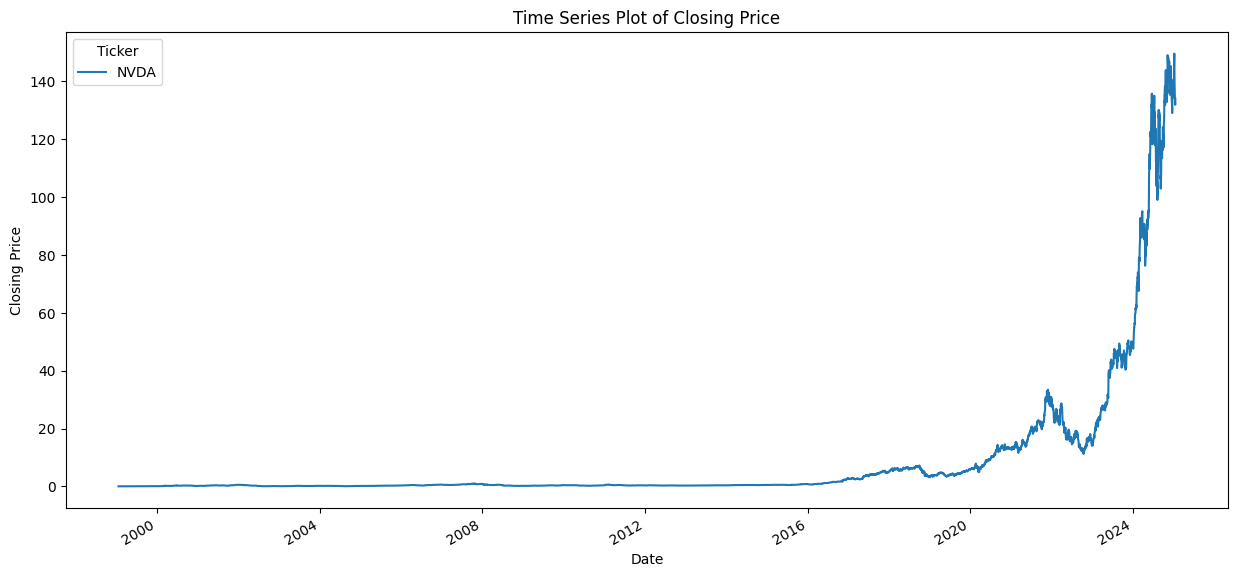

In [7]:
# time series plot
nvda_long_data['Close'].plot(figsize=(15,7))
plt.title('Time Series Plot of Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

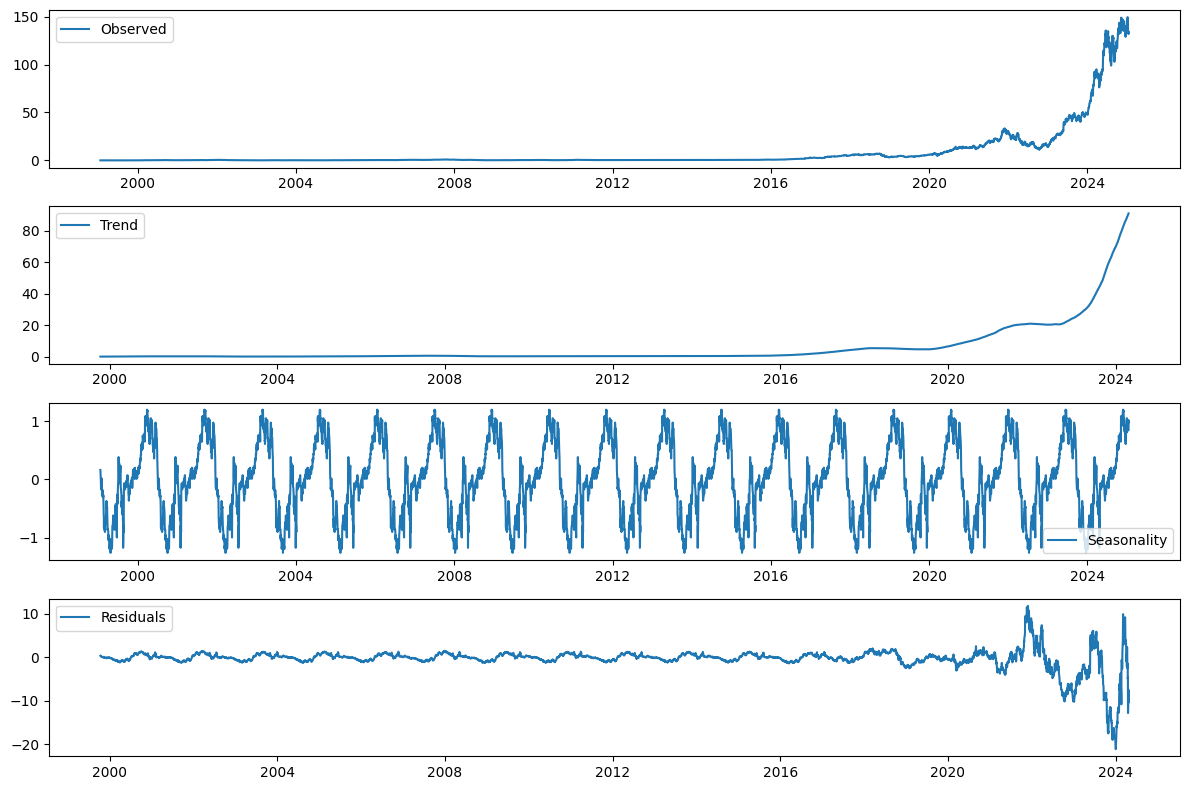

In [8]:
# Decompose the time series into trend, seasonality, and residual
decomposition = seasonal_decompose(nvda_long_data['Close'], model='additive', period=365)

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

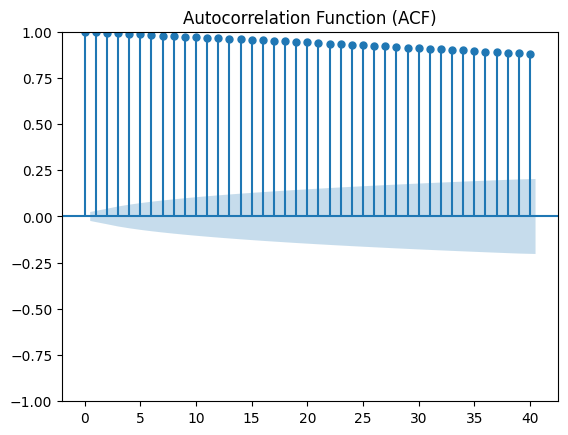

In [9]:
plt.figure(figsize=(10, 5))
plot_acf(nvda_long_data['Close'], lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.show()

<Figure size 1000x500 with 0 Axes>

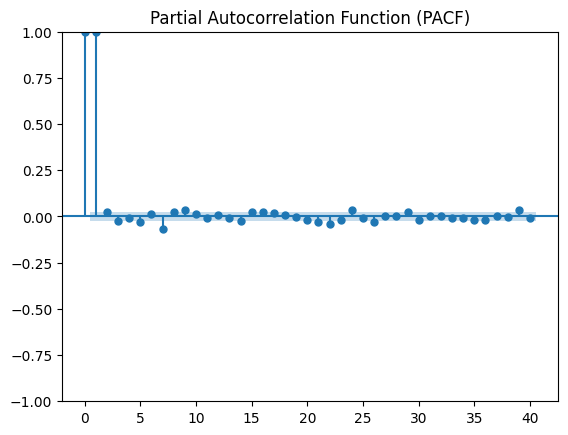

In [10]:
plt.figure(figsize=(10, 5))
plot_pacf(nvda_long_data['Close'], lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [11]:
# get the Date out of the index
nvda_long_data.reset_index(inplace=True)

In [12]:
# isolet the Date and Sales columns
nvda_long_data = nvda_long_data[['Date', 'Close']]

In [13]:
nvda_long_data

Price,Date,Close
Ticker,,NVDA
0,1999-01-22,0.041016
1,1999-01-25,0.045313
2,1999-01-26,0.041797
3,1999-01-27,0.041667
4,1999-01-28,0.041536
...,...,...
6532,2025-01-08,140.110001
6533,2025-01-10,135.910004
6534,2025-01-13,133.229996


In [14]:
# Split into training and testing sets based on index
train_size = int(len(nvda_long_data) * 0.8)  # 80% for training
train_data = nvda_long_data[:train_size]
test_data = nvda_long_data[train_size:]

In [15]:
# set the date coumn as index
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

In [16]:
train_data

Price,Close
Ticker,NVDA
Date,
1999-01-22,0.041016
1999-01-25,0.045313
1999-01-26,0.041797
1999-01-27,0.041667
1999-01-28,0.041536
...,...
2019-10-25,5.113500
2019-10-28,5.169750


In [17]:
test_data

Price,Close
Ticker,NVDA
Date,
2019-11-01,5.064750
2019-11-04,5.262500
2019-11-05,5.240250
2019-11-06,5.190750
2019-11-07,5.208500
...,...
2025-01-08,140.110001
2025-01-10,135.910004


In [18]:
# look at train data date range
train_data.index.min(), train_data.index.max()

(Timestamp('1999-01-22 00:00:00'), Timestamp('2019-10-31 00:00:00'))

In [19]:
# look at the test data date range
test_data.index.min(), test_data.index.max()

(Timestamp('2019-11-01 00:00:00'), Timestamp('2025-01-15 00:00:00'))

In [20]:
scaler = MinMaxScaler()

train_data.loc[:, 'x'] = scaler.fit_transform(train_data[['Close']])
test_data.loc[:, 'x'] = scaler.transform(test_data[['Close']])

In [21]:
# Create sequences for the LSTM model
sequence_length = 100
train_sequences = []
test_sequences = []

for i in range(len(train_data) - sequence_length):
    train_sequences.append(train_data['x'].iloc[i:i+sequence_length].values)

for i in range(len(test_data) - sequence_length):
    test_sequences.append(test_data['x'].iloc[i:i+sequence_length].values)

train_sequences = np.array(train_sequences)
test_sequences = np.array(test_sequences)

In [22]:
# Prepare train and test targets
train_targets = train_data['x'].iloc[sequence_length:].values
test_targets = test_data['x'].iloc[sequence_length:].values

In [23]:
import time
start_time = time.time()

# Create and train an LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_sequences.reshape(-1, sequence_length, 1), train_targets,
epochs=5, batch_size=32)

# Make predictions
test_predictions = model.predict(
                   test_sequences.reshape(-1, sequence_length, 1))

print(time.time() - start_time)

# Inverse transform the predictions to the original scale
test_predictions = scaler.inverse_transform(test_predictions).flatten()
test_targets = scaler.inverse_transform(test_targets.reshape(-1, 1))

Epoch 1/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.0144
Epoch 2/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 2.7620e-04
Epoch 3/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 1.8947e-04
Epoch 4/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 2.0332e-04
Epoch 5/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 1.9702e-04
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
42.729552030563354


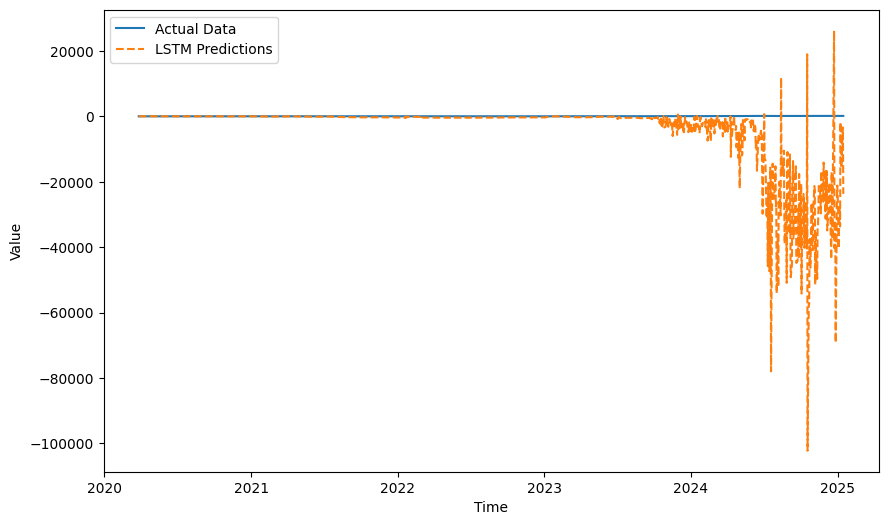

In [24]:
# Plot the original data and LSTM predictions
plt.figure(figsize=(10, 6))
plt.plot(test_data.index[sequence_length:], test_targets,
label="Actual Data", linestyle='-')
plt.plot(test_data.index[sequence_length:], test_predictions,
label="LSTM Predictions", linestyle='--')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(False)
plt.show()

In [25]:
# measure of prediction accuracy
test_predictions_df = pd.DataFrame(test_predictions, columns = ["LSTM"])
test_targets_df = pd.DataFrame(test_targets, columns = ["actuals"])
predictions = pd.concat([test_predictions_df, test_targets_df], axis=1)

wape = (predictions['actuals'] - predictions['LSTM']).abs().sum() / predictions['actuals'].sum()

print(wape * 100)

9806.522958784337


In [26]:
# predict for the next one year
last_sequence = test_sequences[-1]
predicted_values = []

for _ in range(365):
    predicted_value = model.predict(last_sequence.reshape(1, sequence_length, 1))
    predicted_values.append(predicted_value[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = predicted_value

predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1)).flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

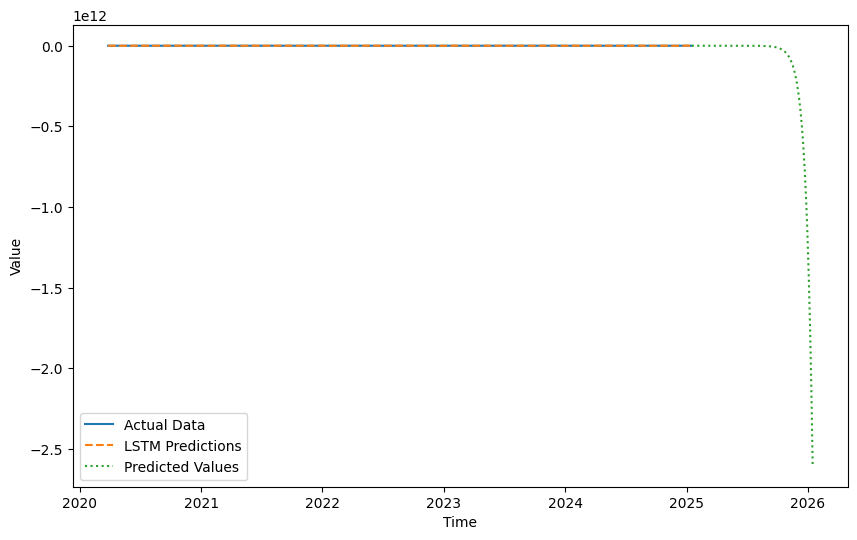

In [27]:
# show in plot
plt.figure(figsize=(10, 6))
plt.plot(test_data.index[sequence_length:], test_targets,
label="Actual Data", linestyle='-')
plt.plot(test_data.index[sequence_length:], test_predictions,
label="LSTM Predictions", linestyle='--')

# Generate a date range for the predicted values
# Assuming your test_data has a daily frequency
from pandas.tseries.offsets import DateOffset
future_dates = pd.date_range(start=test_data.index[-1], periods=365 + 1, freq='D')[1:]  # Exclude the start date

# Now plot the predicted values against the future dates
plt.plot(future_dates, predicted_values,
         label="Predicted Values", linestyle=':')

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(False)
plt.show()